# Latent Space Visualization using Variational Autoencoder

## Karthick Kumaran Ayyalluseshagiri Viswanathan
### IMGS789

### Assignment-2
### Latent Space Visualization using Variational Autoencoder

In [1]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-aps17yuk
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-aps17yuk
  Resolved https://github.com/tensorflow/docs to commit 15e96c3ee154d7c10ec9bb807ef44b4e6f08e65b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.10.14.18741-py3-none-any.whl size=182607 sha256=fbae217b0f1655043be55951980ab02369a9b36664add32be7f32314273f44b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-rf3wrbr3/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [7]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [8]:
# Load the MNIST data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [9]:
# Preprocess the images
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [10]:
train_size = 60000
batch_size = 32
test_size = 10000

In [11]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [12]:
class VariationalAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(VariationalAutoencoder, self).__init__()
    self.latent_dim = latent_dim

    # Define the Encoder
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    # Define the Decoder
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.
  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [14]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VariationalAutoencoder(latent_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [15]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  # if epoch % 10 == 0:
  plt.tight_layout()
  plt.show()

In [16]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

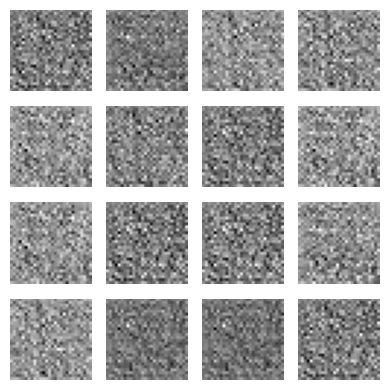

Epoch: 1, Test set ELBO: -181.10768127441406, time elapse for current epoch: 11.603574275970459
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.651415   -0.51984185]
 [-1.0968068   0.8506528 ]
 [-0.24733517 -0.11517824]
 [-0.6524843  -0.57208717]
 [-0.6266321   0.27161512]
 [-0.31929693 -1.3396649 ]
 [-1.0236592  -1.2847681 ]
 [-1.3468077   0.7216996 ]
 [-0.70914125 -0.9234538 ]
 [-0.12028581  0.10178214]
 [-0.90496206 -0.7165186 ]
 [-0.8460994  -0.9151048 ]
 [-0.73868597 -1.9827162 ]
 [-0.91678107 -0.30906725]
 [-0.22114134  0.39999044]
 [-0.75680614 -1.0298201 ]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-4.758818  -4.6665173]
 [-4.4520063 -4.4751782]
 [-4.773878  -4.6085553]
 [-4.1251903 -4.046576 ]
 [-4.7898355 -4.908422 ]
 [-4.1307836 -3.9141872]
 [-4.0647655 -3.733695 ]
 [-4.3687315 -4.394776 ]
 [-3.9227457 -3.6025548]
 [-5.443501  -5.3137665]
 [-4.362313  -4.2252254]
 [-4.345185  -4.148588 ]
 [-4.011102  -3

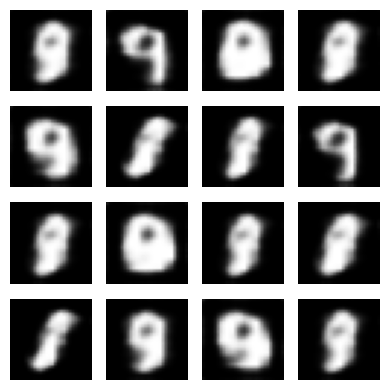

Epoch: 2, Test set ELBO: -171.78680419921875, time elapse for current epoch: 7.666202068328857
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.30285034 -0.269672  ]
 [-1.2824769   1.3012546 ]
 [-0.0660645  -0.09039041]
 [-0.22530706 -0.50254995]
 [-0.7518109   0.5257068 ]
 [-0.06151412 -1.1688728 ]
 [-0.98632145 -0.82790023]
 [-1.3798584   1.0286303 ]
 [-0.41419438 -0.63382477]
 [-0.08293398 -0.16339283]
 [-0.8748207  -0.30274206]
 [-0.50618595 -0.62366647]
 [-0.5345739  -1.8734438 ]
 [-0.61700153 -0.14635439]
 [-0.2140786   0.93659705]
 [-0.4930664  -0.709147  ]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.1394486 -5.409204 ]
 [-4.6563044 -4.961256 ]
 [-5.1980004 -5.2426763]
 [-4.786556  -5.014267 ]
 [-5.0181384 -5.1205673]
 [-4.7952623 -4.5630984]
 [-4.791427  -4.4972963]
 [-4.738253  -5.0353465]
 [-4.752191  -4.445047 ]
 [-5.48363   -5.595847 ]
 [-4.883439  -4.85239  ]
 [-4.9903417 -5.0045505]
 [-4.825701  -4.

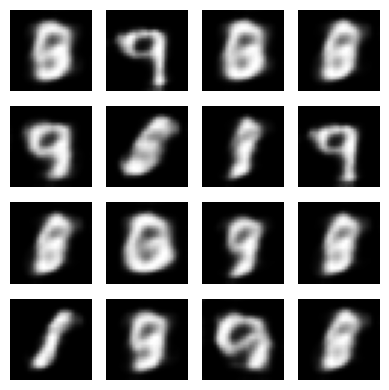

Epoch: 3, Test set ELBO: -167.7093963623047, time elapse for current epoch: 8.275245904922485
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.23976606 -0.03513028]
 [-1.3528302   1.7222115 ]
 [ 0.19275674  0.09555799]
 [ 0.03052334 -0.4507602 ]
 [-0.75125694  0.8460444 ]
 [ 0.0973336  -1.2250983 ]
 [-1.0491935  -0.58363974]
 [-1.3845344   1.4231813 ]
 [-0.2246879  -0.43732378]
 [ 0.14766657 -0.03163675]
 [-0.9786654  -0.08243837]
 [-0.397537   -0.4326501 ]
 [-0.40927625 -1.9053214 ]
 [-0.46737742  0.06840056]
 [-0.06146391  1.4199231 ]
 [-0.5377211  -0.56031895]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.3072977 -5.650362 ]
 [-4.4725547 -4.7901964]
 [-5.274896  -5.18413  ]
 [-4.738929  -5.1372857]
 [-5.037231  -4.9398937]
 [-4.9347086 -4.5648355]
 [-4.852877  -4.500316 ]
 [-4.5221744 -4.8738556]
 [-4.8988295 -4.368668 ]
 [-5.6457872 -5.7725005]
 [-4.845895  -4.8858647]
 [-5.086255  -5.250013 ]
 [-5.0417104 -4.2

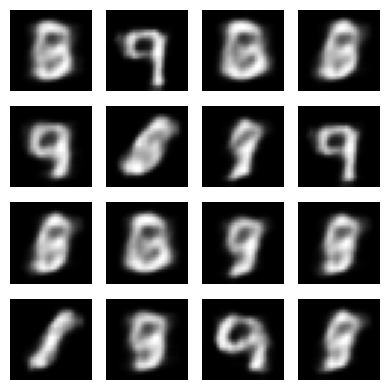

Epoch: 4, Test set ELBO: -164.1371612548828, time elapse for current epoch: 8.284194707870483
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.2742113   0.17935002]
 [-1.457358    2.0280616 ]
 [ 0.49367583  0.15444458]
 [ 0.2797688  -0.43082845]
 [-0.84273714  1.1129929 ]
 [ 0.14425673 -1.185411  ]
 [-1.1556071  -0.43242002]
 [-1.5104634   1.6649904 ]
 [-0.09619582 -0.2428393 ]
 [ 0.4549819  -0.00836344]
 [-1.082497    0.01548056]
 [-0.2882226  -0.22286773]
 [-0.46058196 -1.9295359 ]
 [-0.36811483  0.23294851]
 [ 0.06739962  1.8108823 ]
 [-0.56283456 -0.48313552]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.168595  -5.645549 ]
 [-4.307843  -4.598214 ]
 [-5.122484  -5.0733967]
 [-4.6494055 -5.288241 ]
 [-4.8120413 -4.621576 ]
 [-4.9168663 -4.6038914]
 [-4.841695  -4.6154   ]
 [-4.2297254 -4.573937 ]
 [-4.9172516 -4.2669826]
 [-5.417751  -5.7486796]
 [-4.7256126 -5.014911 ]
 [-4.975778  -5.3450727]
 [-5.122034  -4.3

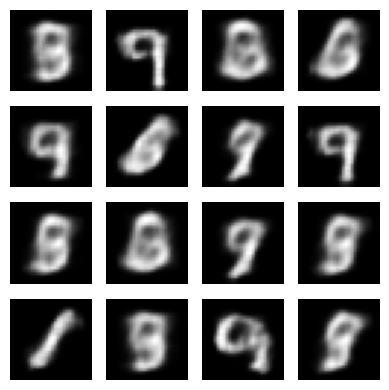

Epoch: 5, Test set ELBO: -161.8037567138672, time elapse for current epoch: 8.274457931518555
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.25950807  0.26833904]
 [-1.521343    2.2618456 ]
 [ 0.6592011   0.22612293]
 [ 0.35312173 -0.39446872]
 [-0.9389389   1.3246784 ]
 [ 0.11221065 -1.1638696 ]
 [-1.2463256  -0.37808752]
 [-1.6077586   1.9366314 ]
 [ 0.02089182 -0.13811411]
 [ 0.6146026   0.0731602 ]
 [-1.1644282   0.01265548]
 [-0.19701415 -0.11305258]
 [-0.4836295  -1.8703551 ]
 [-0.31910968  0.33857435]
 [ 0.10186993  2.1481318 ]
 [-0.6076746  -0.42040765]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.2627234 -5.607828 ]
 [-4.346793  -4.4483557]
 [-5.3588033 -5.0452166]
 [-4.9652357 -5.4044876]
 [-4.699686  -4.493414 ]
 [-5.0976605 -4.892851 ]
 [-5.0928683 -4.76171  ]
 [-4.2737536 -4.408807 ]
 [-4.9334464 -4.288228 ]
 [-5.613483  -5.6528788]
 [-5.0225244 -5.124202 ]
 [-5.148007  -5.3413286]
 [-5.2596717 -4.5

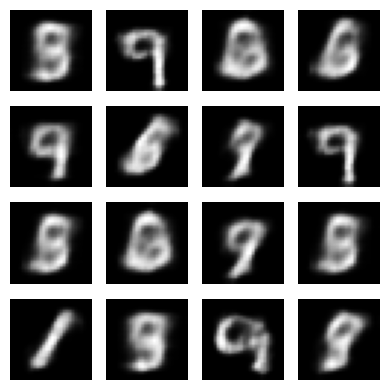

Epoch: 6, Test set ELBO: -160.23880004882812, time elapse for current epoch: 8.577840089797974
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.30347428  0.34169012]
 [-1.4876167   2.3656337 ]
 [ 0.7457706   0.21711078]
 [ 0.41967502 -0.3624062 ]
 [-1.016636    1.4212877 ]
 [ 0.13420272 -1.0924062 ]
 [-1.2548409  -0.31790102]
 [-1.5997899   2.0067766 ]
 [ 0.10686715 -0.09390805]
 [ 0.6536967   0.03872251]
 [-1.1299043   0.02634932]
 [-0.1541456  -0.02360348]
 [-0.47010562 -1.7018398 ]
 [-0.30719295  0.36507285]
 [ 0.09092242  2.2546628 ]
 [-0.5415048  -0.36206394]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.46032   -5.6021852]
 [-4.4171386 -4.3452144]
 [-5.572742  -5.2035747]
 [-5.152627  -5.5381722]
 [-4.72139   -4.5051637]
 [-5.2620625 -4.9995775]
 [-5.2772183 -4.881702 ]
 [-4.409949  -4.3686247]
 [-4.958195  -4.19312  ]
 [-5.7612057 -5.7117515]
 [-5.221963  -5.182648 ]
 [-5.345644  -5.326229 ]
 [-5.463958  -4.

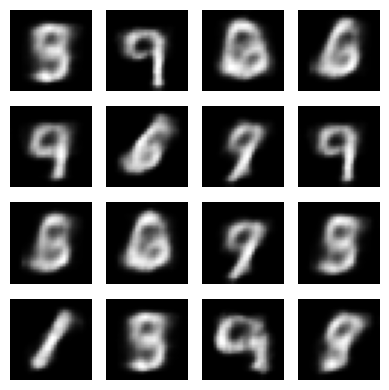

Epoch: 7, Test set ELBO: -159.35755920410156, time elapse for current epoch: 8.32580041885376
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.3382711   0.3762334 ]
 [-1.4533924   2.434788  ]
 [ 0.8735245   0.23500921]
 [ 0.47669673 -0.30852827]
 [-1.0108647   1.4687954 ]
 [ 0.14053601 -1.0753423 ]
 [-1.2558157  -0.33147568]
 [-1.6152691   2.0968385 ]
 [ 0.16341352 -0.02356271]
 [ 0.7628813   0.11131284]
 [-1.1286724   0.04807756]
 [-0.1862959   0.04616198]
 [-0.5056936  -1.6750247 ]
 [-0.3306186   0.42781633]
 [ 0.19083482  2.405504  ]
 [-0.5137802  -0.36091468]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.6781273 -5.539823 ]
 [-4.6392393 -4.3481593]
 [-5.9384956 -5.204976 ]
 [-5.48538   -5.5441427]
 [-5.263467  -4.3373737]
 [-5.520324  -5.0774755]
 [-5.661292  -4.872406 ]
 [-4.578033  -4.2628164]
 [-5.143772  -4.1420636]
 [-6.164665  -5.721412 ]
 [-5.6756625 -5.1623483]
 [-5.609247  -5.2884917]
 [-5.7993603 -4.7

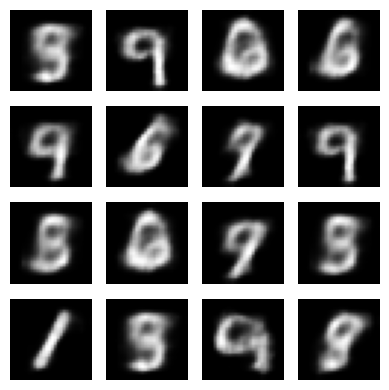

Epoch: 8, Test set ELBO: -158.2985076904297, time elapse for current epoch: 8.286218404769897
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.2570198   0.41344997]
 [-1.4603673   2.4593124 ]
 [ 0.87471217  0.18834011]
 [ 0.4889174  -0.3447265 ]
 [-1.040272    1.6121935 ]
 [ 0.24142022 -1.0620517 ]
 [-1.1918811  -0.34502822]
 [-1.6396747   2.1721098 ]
 [ 0.2166992   0.00678645]
 [ 0.74404025  0.06623376]
 [-1.1272715   0.07150625]
 [-0.06207911  0.06944368]
 [-0.40333334 -1.6310271 ]
 [-0.2351883   0.4350483 ]
 [ 0.11592467  2.5299926 ]
 [-0.46188286 -0.3426638 ]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.6939573 -5.6892347]
 [-4.3879867 -4.4360056]
 [-5.9563675 -5.358492 ]
 [-5.3915205 -5.6056614]
 [-5.1416965 -4.5456114]
 [-5.4550166 -5.215888 ]
 [-5.477169  -4.9707184]
 [-4.423829  -4.387704 ]
 [-5.1311717 -4.2370934]
 [-6.1069136 -5.756422 ]
 [-5.463738  -5.165962 ]
 [-5.613116  -5.4043856]
 [-5.678692  -4.9

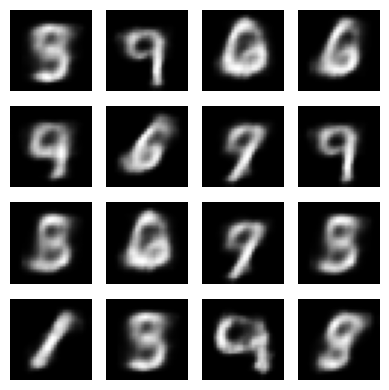

Epoch: 9, Test set ELBO: -157.50595092773438, time elapse for current epoch: 9.028536081314087
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.27347916  0.4444584 ]
 [-1.3932471   2.5121899 ]
 [ 0.913587    0.229982  ]
 [ 0.47822374 -0.2846301 ]
 [-1.0065477   1.5877764 ]
 [ 0.21763737 -1.0503664 ]
 [-1.1799346  -0.30463094]
 [-1.611683    2.232334  ]
 [ 0.2528507   0.04878541]
 [ 0.75911564  0.12727493]
 [-1.1509162   0.08879021]
 [-0.09444406  0.12299186]
 [-0.45087808 -1.5880578 ]
 [-0.2683273   0.45819303]
 [ 0.18070292  2.6059809 ]
 [-0.38830382 -0.34295598]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-5.7617893 -5.7769537]
 [-4.1776447 -4.5761123]
 [-5.8592796 -5.5190687]
 [-5.41364   -5.8798804]
 [-4.9898944 -4.5986614]
 [-5.4249067 -5.366091 ]
 [-5.441747  -5.1016917]
 [-4.3000817 -4.430192 ]
 [-5.0347543 -4.2697487]
 [-5.987562  -5.879223 ]
 [-5.3752227 -5.3028874]
 [-5.580425  -5.506353 ]
 [-5.7155294 -5.

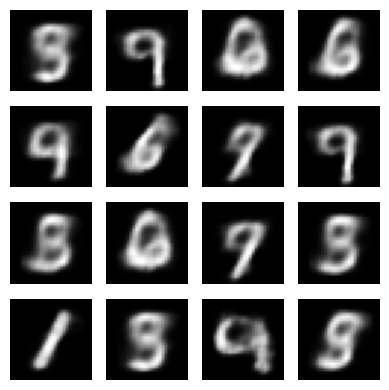

Epoch: 10, Test set ELBO: -156.54685974121094, time elapse for current epoch: 12.260229349136353
Predictions :  <class 'tensorflow.python.framework.ops.EagerTensor'> (16, 28, 28, 1)
Mean :  tf.Tensor(
[[-0.25123516  0.43430763]
 [-1.3393619   2.474226  ]
 [ 1.0040841   0.22510259]
 [ 0.51767856 -0.25162116]
 [-1.0388348   1.5801498 ]
 [ 0.26729172 -1.0630977 ]
 [-1.1827774  -0.3081747 ]
 [-1.5582356   2.2062995 ]
 [ 0.3263968   0.08962841]
 [ 0.82011306  0.13614641]
 [-1.146863    0.10810927]
 [-0.05169361  0.08891181]
 [-0.40955254 -1.5673243 ]
 [-0.23263869  0.46087256]
 [ 0.2008137   2.5735667 ]
 [-0.33760154 -0.368869  ]], shape=(16, 2), dtype=float32)
logvar :  tf.Tensor(
[[-6.1515923 -5.846557 ]
 [-4.6264315 -4.507182 ]
 [-6.1773195 -5.4742103]
 [-5.7389674 -5.83349  ]
 [-5.4374585 -4.622112 ]
 [-5.6344514 -5.52787  ]
 [-5.708273  -5.132354 ]
 [-4.6744456 -4.4195595]
 [-5.2764    -4.33112  ]
 [-6.2788186 -5.7820287]
 [-5.672738  -5.272411 ]
 [-5.863414  -5.5506697]
 [-5.9813275 -

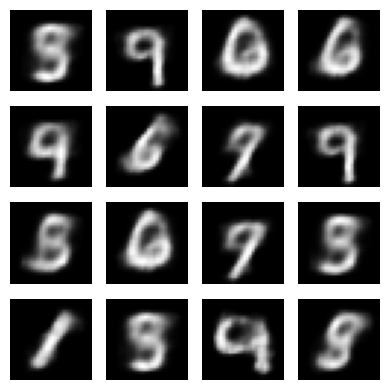

In [17]:
generate_and_save_images(model, 0, test_sample)

elbo_loss = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  elbo_loss.append(elbo)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  print('Predictions : ', type(predictions), predictions.shape)
  print('Mean : ', mean)
  print('logvar : ', logvar)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  # if epoch % 10 == 0:
  plt.tight_layout()
  plt.show()

In [18]:
print(test_images.shape)

(10000, 28, 28, 1)


In [19]:
print(test_sample.shape)

(16, 28, 28, 1)


(16, 2)


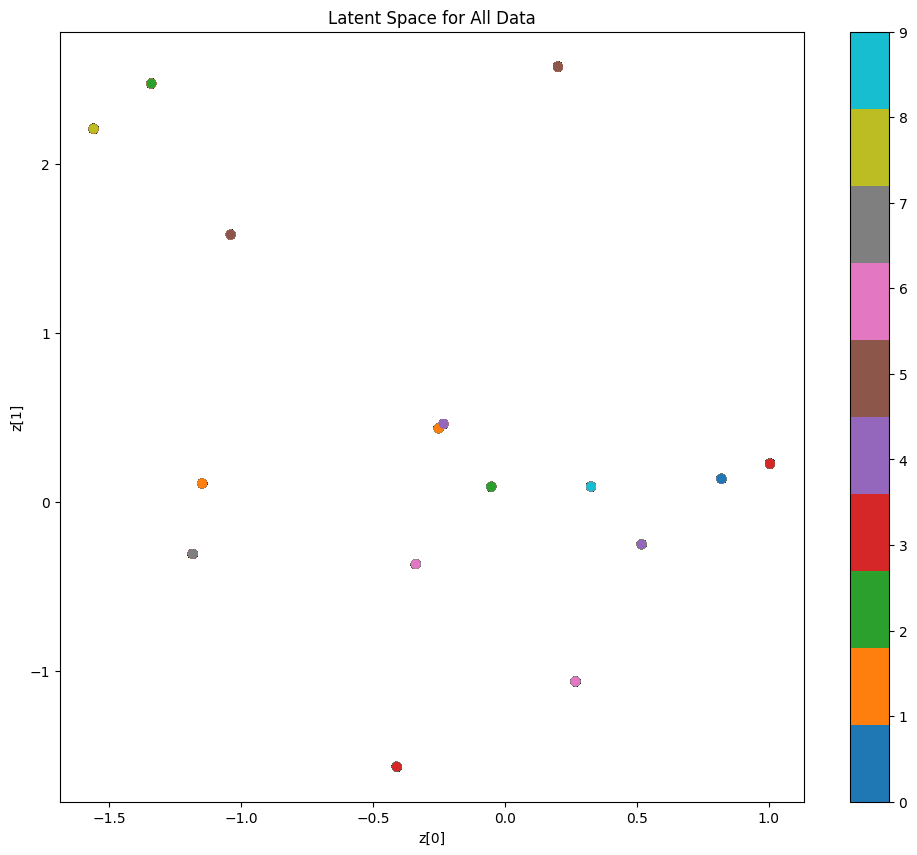

In [46]:
# Latent space visualization
totalmean = np.zeros((10000, 2))
totallogvar = np.zeros((10000, 2))
plt.figure(figsize=(12, 10))
for i in range(0, 10000, 16):
  imgs = test_images[i : i + 16]
  lbls = test_labels[i : i + 16]

  mean, logvar = model.encode(test_sample)
  for x in range(i, i+16, 1):
    totalmean[x] = mean[x - i]
    totallogvar[x] = logvar[x - i]

plt.scatter(totalmean[:, 0], totalmean[:, 1], c=test_labels)
plt.colorbar()
plt.set_cmap('tab10')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Latent Space for All Data')
plt.show()



In [48]:
print(totalmean.shape)

(10000, 2)
